In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **통계 기반 기법의 문제점**

통계 기반 기법에서 대규모 말뭉치를 다룰 때 거대 행렬에 SVD를 적용하는 일은 현실적이지 않다.

통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)를 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻는다.

한편 추론 기반 기법에서는, 예컨대 신경망을 이용하는 경우는 미니배치로 학습하는 것이 일반적이다. 미니배치 학습에서는 신경망이 한번에 소량(미니배치)의 학습 샘플씩 반복해서 학습하며 가중치를 갱신해나간다.

추론 기반 기법은 학습 데이터의 일부를 사용하여 순차적으로 학습하므로(미니배치) 말뭉치의 어휘 수가 많아 SVD등 계산량이 큰 작업을 하기 어려운 경우에도 신경망을 학습시킬 수 있다. GPU를 이용한 병렬 계산도 가능해져서 학습 속도를 높일 수도 있다.

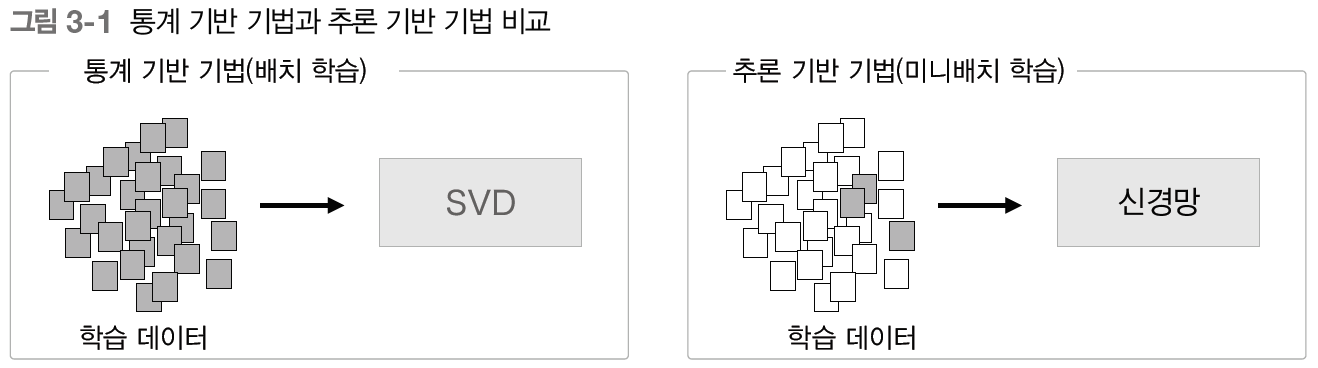

## **추론 기반 기법 개요**

추론 기반 기법에서는 당연히 '추론'이 주된 작업이다. 주변 단어(맥락)가 주어졌을 때 "?"에 무슨 단어가 들어가는지를 추측하는 작업이 추론이다.

추론 기반 기법에는 어떠한 모델이 등장한다. 우리는 이 모델로 신경망을 사용한다. 모델은 맥락 정보를 입력받아 (출현할 수 있는) 각 단어의 출현 확률을 출력한다. 이러한 틀 안에서 말뭉치를 사용해 모델이 올바른 추측을 내놓도록 학습시킨다. 그리고 그 학습의 결과로 단어의 분산 표현을 얻는 것이 추론 기반 기법의 전체 그림이다.

## **신경망에서의 단어 처리**

신경망을 이용해 '단어'를 처리할때, '고정 길이의 벡터'로 변환해야 하기 때문에 단어를 **원핫(one-hot)표현 (또는 원핫 벡터)**으로 변환한다.

따라서 단어를 벡터로 나타낼 수 있고, 신경망을 구성하는 '계층'들은 벡터를 처리할 수 있다. 다시 말해, 단어를 신경망으로 처리할 수 있다.

자 이제, 완전연결계층에 의한 변환을 살펴보자.

In [2]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # 입력
W = np.random.randn(7, 3)               # 가중치
h = np.matmul(c, W)                     # 중간 노드
print(h)                                 

[[-0.46885497  1.78996124  0.68258345]]


이 코드는 단어 ID가 0인 단어를 원핫 표현으로 표현한 다음 완전연결계층을 통과시켜 변환하는 모습이다.

c와 W의 행렬 곱은 결국 ID에 해당하는 가중치의 행벡터 하나를 '뽑아낸'것과 같다.

가중치로부터 행벡터를 뽑아낼 뿐인데 행렬 곱을 계산하는 건 비효율적이라고 생각되지만, 이는 다음 절에서 개선할 예정이다. 앞의 작업을 MatMul 계층으로 수행할 수 있다.

In [3]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'
import sys
sys.path.append(path)
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 1.33954469 -0.63287463  0.1695095 ]]


## **CBOW 모델의 추론 처리**

CBOW 모델은 맥락으로부터 타깃(target)을 추측하는 용도의 신경망이다('타깃'은 중앙 단어이고 그 주변 단어들이 '맥락'이다). 우리는 이 CBOW 모델이 가능한 한 정확하게 추론하도록 훈련시켜 단어의 분산 표현을 얻어낸다.

학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 갱신될 것이다. 또한 이렇게 얻은 벡터에는 '단어의 의미'도 잘 녹아들어 있다.

은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 중요하다. 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 '간결하게' 담게 되며, 결과적으로 밀집벡터 표현을 얻을 수 있다.

CBOW 모델의 추론 처리를 파이썬으로 구현해보자. (추론 처리란 소프트맥스 함수를 통해 확률로 출력되기 전의 '점수'를 구하는 처리를 말한다).

In [4]:
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)         # 은닉층 뉴런의 평균
s = out_layer.forward(h)
print(s)

[[-1.63406804  0.99975161  0.48800463  0.41172561 -0.74002995 -1.87985646
   2.35602763]]


이상이 CBOW 모델의 추론 과정이다. 여기서 보았듯 CBOW 모델은 활성화 함수를 사용하지 않는 간단한 구성의 신경망이다. 입력층이 여러 개 있고 그 입력층들이 가중치를 공유한다.

## **CBOW 모델의 학습**

지금까지 설명한 CBOW 모델은 출력층에서 각 단어의 점수를 출력했다. 이 점수에 소프트맥스 함수를 적용하면 '확률'을 얻을 수 있고, 이 확률은 맥락(전후 단어)이 주어졌었을 때 그 중앙에 어떤 단어가 출현하는지를 나타낸다.

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다. 그 결과로 가중치에 단어의 출현 패턴을 파악한 벡터가 학습된다. CBOW 모델로 얻을 수 있는 단어의 분산 표현은 우리의 직관에 부합하는 경우가 많다. 

우리가 앞으로 구현할 신경망의 정확한 모습은 다음과 같다.

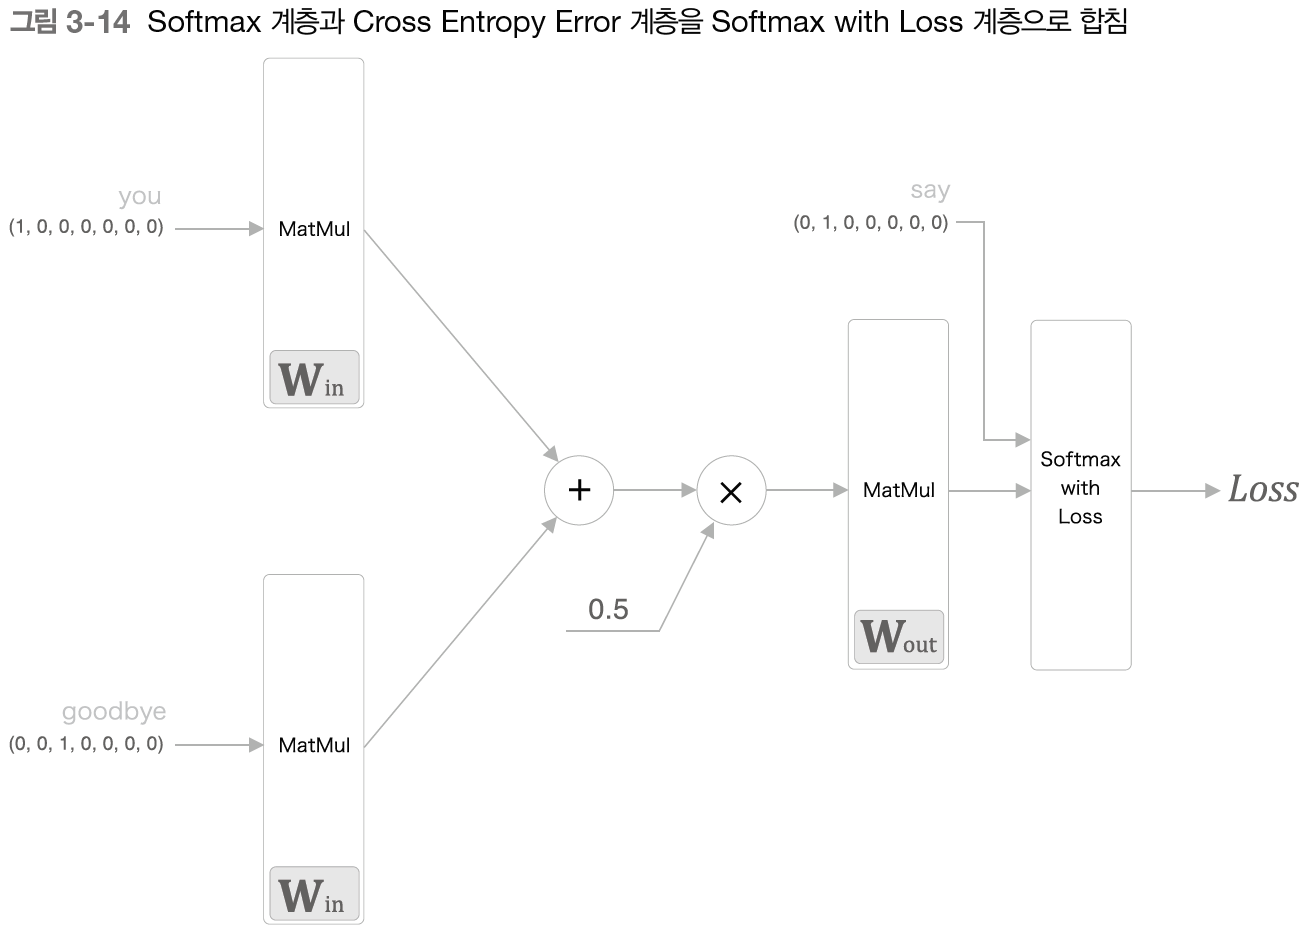

## **word2vec의 가중치와 분산 표현**

최종적으로 이용하는 단어의 분산 표현으로 선택할 가중치에는 세가지 선택지가 있다.

* 입력 층의 가중치만 이용한다.
* 출력 층의 가중치만 이용한다.
* 양쪽 가중치를 모두 이용한다.

word2vec 에서는 첫번째 안인 '입력 측의 가중치만 이용한다'가 가장 대중적인 선택이다. 많은 연구에서 출력 층 가중치는 버리고 입력 측 가중치 $W_{in}$만을 최종 단어의 분산 표현으로서 이용한다. 우리도 이를 따라서 $W_{in}$을 단어의 분산 표현으로 이용한다. 

## **맥락과 타깃**

word2vec에서 이용하는 신경망의 입력은 '맥락'이다. 그리고 그 정답 레이블은 맥락에 둘러 싸인 중앙의 단어, 즉 '타깃'이다. 우리가 해야 할 일은 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다.

말뭉치로부터 맥락과 타깃을 만드느 함수를 구현해보자.

In [5]:
# 말뭉치 텍스트를 단어 ID로 변환

from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [6]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
# 맥락과 타깃을 만드는 함수 구현

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size : -window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t ==0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [9]:
print(target)

[1 2 3 4 1 5]


이를 CBOW 모델에 넘겨주면 된다. 하지만 맥락과 타깃의 각 원소가 단어 ID이므로 원핫 표현으로 변환해보자.

## **원핫 표현으로 변환**

맥락과 타깃을 단어 ID에서 원핫 표현으로 변환해보자. 이때 다시 하번 각각의 다차원 배열의 형상에 주목해야 한다.

In [10]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

지금까지의 데이터 준비 과정을 한 데 모아 정리해보자.

In [11]:
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

이것으로 학습 데이터 준비를 마쳤다.

## **CBOW 모델 구현**

우리가 구현할 신경망에 대해서 다시 살펴보자.

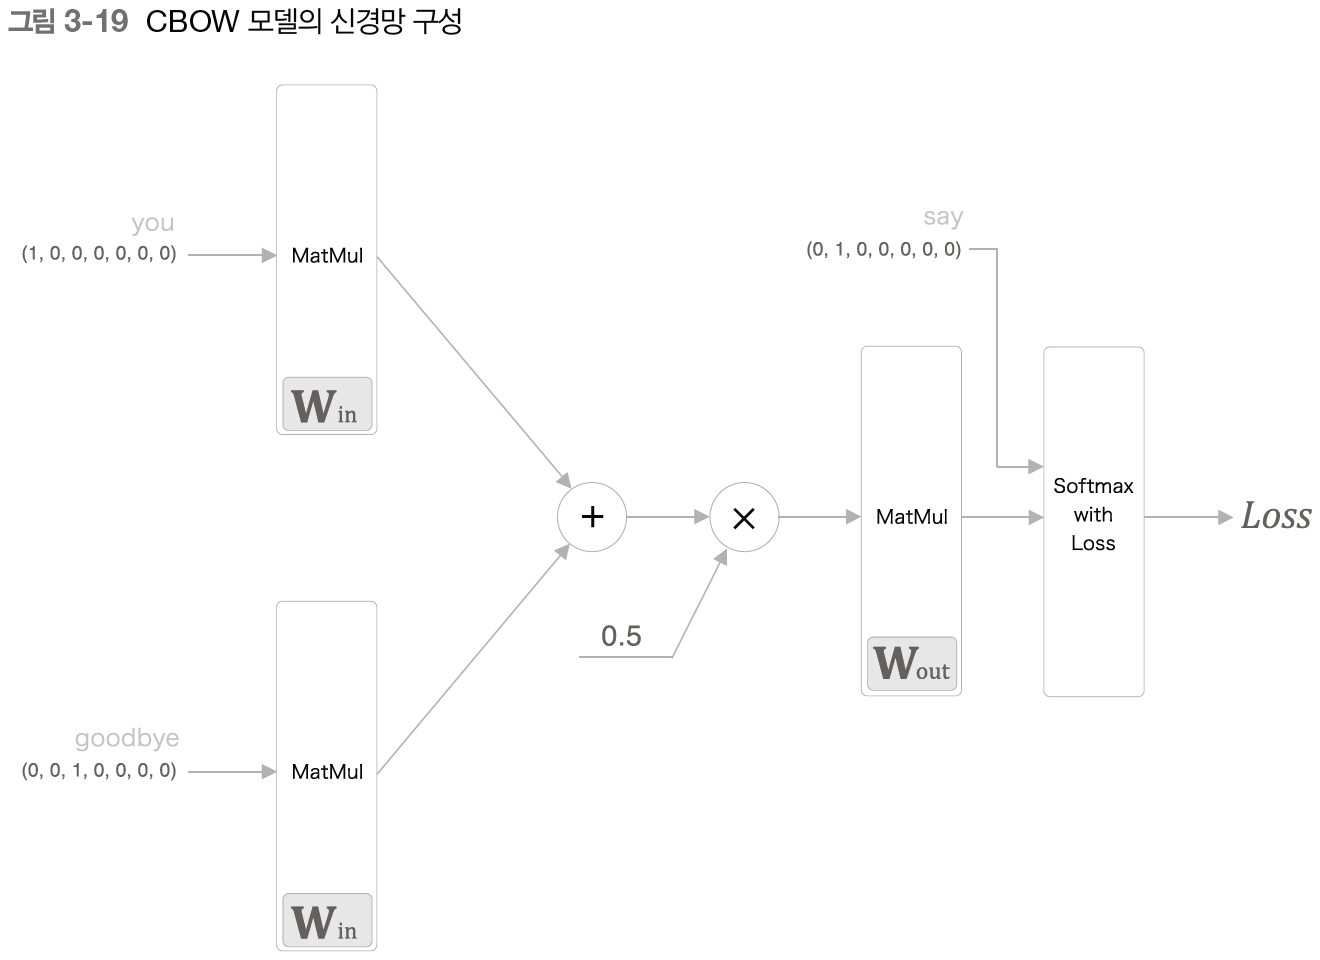

In [12]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):        # 초기화 메서드 구현
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')     # 32비트 부동소수점 수
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):        # 순전파 메서드 구현
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5                     # 평균을 구하기 위한 덧셈 + 곱셈노드 (0.5)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):                 # 역전파 메서드 구현
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5                               # 순전파에서 구했던 평균을 구하기 위한 곱셈 노드 (0.5)
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## **학습 코드 구현**

학습 데이터를 준비해 신경망에 입력한 다음, 기울기를 구하고 가중치 매개변수를 순서대로 갱신하자. 이번 학습 과정을 수행하는데 1장에서 설명한 Trainer 클래스를 사용할 것이다.

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

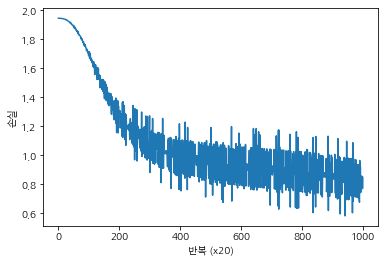

In [15]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()                          # optimizer로 Adam 알고리즘 선택
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

학습을 거듭할수록 손실이 줄어든다. 즉 학습이 순조롭게 이루어 지고 있다. 학습이 끝난 후의 가중치 매개변수를 확인해보자.

In [17]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.2249328  1.1665604 -1.2024475 -1.1434146  1.1592841]
say [-1.17943   -1.1613594  1.177939   1.0212957 -1.229314 ]
goodbye [ 0.7237869   0.81362146 -0.76023656 -0.87707716  0.6770426 ]
and [-1.1256651 -1.1447393  0.6788746  1.612955  -0.9675896]
i [ 0.7032388   0.7981551  -0.75991607 -0.84769636  0.68666416]
hello [ 1.2309227  1.1700261 -1.227853  -1.153012   1.1640581]
. [-0.8223751  -0.7439723   1.3546383  -0.39601496 -1.2198359 ]


마침내 단어를 희소벡터가 아닌 밀집벡터로 나타낼 수 있게 되었다. 이 밀집벡터가 바로 단어의 분산 표현이다. 학습이 잘 이뤄졌으니 (그래프 확인 결과) 이 분산 표현은 '단어의 의미'를 잘 파악한 벡터 표현으로 되어 있을 것이라 기대할 수 있다.

하지만 작은 말뭉치로는 좋은 결과를 얻을 수 없다. 실용적이고 충분히 큰 말뭉치로 바꾸면 결과도 그만큼 좋아지겠지만, 처리 속도 면에서 문제가 생긴다. 현시점의 CBOW 모델 구현은 처리 효율 면에서 몇 가지 문제가 있다. 다음 장에서 '단순한' COBW 모델을 개선하여 '진짜' CBOW 모델을 구현한다.

## **CBOW 모델과 확률**

$w_{t-1}$과 $w_{t+1}$이 주어졌을 때 타깃이 $w_t$가 될 확률은 사후 확률을 사용해 다음처럼 쓸 수 있다.

$$P(w_t | w_{t-1}, w_{t+1})$$

위 식은 '$w_{t-1}$과 $w_{t+1}$이 일어난 후 $w_t$가 일어날 확률'을 뜻한다. CBOW는 이 식을 모델링 하고 있는 것이다.

이 식을 이용하여 CBOW 모델의 손실 함수도 간결하게 표현할 수 있다.

$$L = -logP(w_t | w_{t-1}, w_{t+1})$$

이를 **음의 로그 가능도(negative log likelihood)**라 한다. 이는 샘플 데이터 하나에 대한 손실 함수이므로, 확장하면 다음과 같다.

$$L = -\frac{1}{T}\sum_{t=1}^T logP(w_t | w_{t-1}, w_{t+1})$$

CBOW 모델의 학습이 수행하는 일은 이 손실 함수의 값을 가능한 한 작게 만드는 것이다. 그리고 이때의 가중치 매개변수가 우리가 얻고자 하는 단어의 분산 표현인 것이다.

## **skip-gram 모델**

word2vec은 2개의 모델을 제안하고 있다. 하나는 지금까지 본 CBOW 모델이고, 다른 하나는 skip-gram 모델이다. skip-gram은 CBOW에서 다루는 맥락과 타깃을 역전 시킨 모델이다. 즉, 맥락에 주목해 사이에 들어올 단어를 추론하는 CBOW 모델과 달리 한 단어에 주목해 그 주변 맥락에 어떤 단어가 올지를 추론하는 것이다.

따라서 skip-gram 모델의 입력층은 하나이고, 출력층은 맥락의 수만큼 존재한다. 따라서 각 출력층에서는 (Softmax with Loss 계층 등을 이용해) 개별적으로 손실을 구하고, 이 개별 손실들을 모두 더한 값을 최종 손실로 한다.

skip-gram은 다음을 모델링 한다.

$$P(w_{t-1}, w_{t+1} | w_t)$$

여기서 skip-gram 모델에서는 맥락의 단어들 사이에 관련성이 없다고 가정하고 다음과 같이 분해한다 (정확하게 '조건부 독립'이라고 가정한다).

$$P(w_{t-1}, w_{t+1} | w_t) = P(w_{t-1} | w_t) P(w_{t+1} | w_t)$$

이어서 위 식을 교차 엔트로피 오차에 적용하여 skip-gram 모델의 손실 함수를 유도할 수 있다.

$$ L = -logP(w_{t-1}, w_{t+1} | w_t) $$
$$ =  -logP(w_{t-1} | w_t) P(w_{t+1} | w_t) $$
$$ = -(logP(w_{t-1} | w_t) + logP(w_{t+1} | w_t))$$

이를 말뭉치 전체로 확장하면 skip-gram 모델의 손실 함수는 다음과 같다.

$$ L = -\frac{1}{T}\sum_{t=1}^T(logP(w_{t-1} | w_t) + logP(w_{t+1} | w_t)) $$

skip-gram 모델은 맥락의 수만큼 추측하기 때문에 그 손실 함수는 각 맥락에서 구한 손실의 총합이어야 한다. 반면, CBOW 모델은 타깃 하나의 손실을 구한다.

단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋은 경우가 많고, 말뭉치가 커질수록 단어나 유추문제의 성능 면에서 skip-gram 모델이 더 뛰어난 경향이 많으므로 일반적으로 skip-gram 모델이 CBOW 모델보다 더 좋은 모델이라고 할 수 있다.

하지만 skip-gram 모델은 손실을 맥락의 수만큼 구해야 해서 계산 비용이 그만큼 거지기 때문에 학습 속도 면에서는 CBOW 모델이 더 빠르다.

## **통계 기반 vs 추론 기반**

통계 기반 기법은 말뭉치의 전체 통계로부터 1회 학습하여 단어의 분산 표현을 얻었다. 한편, 추론 기반 기법(특히 word2vec)에서는 말뭉치를 일부분씩 여러 번 보면서 학습했다(미니배치 학습).

어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신해야 하는 상황에서는 추론 기반 기법(word2vec)이 우세하다. 통계 기반 기법에서는 단어의 분산 표현을 조금만 수정하고 싶어도 전체 프로세스를 다시 해야하는데, 추론 기반 기법(word2vec)은 지금까지 학습한 가중치를 초깃값으로 사용해 다시 학습하면 기존에 학습한 경험을 해치지 않으면서 단어의 분산 표현을 효율적으로 갱신할 수 있기 때문이다.

단어의 분산 표현의 성격이나 정밀도 면에서는 추론 기반과 통계 기반 기법의 우열을 가릴 수 없다.

또 다른 중요한 사실로, 추론 기반 기법과 통계 기반 기법은 서로 관련되어 있다. 두 세계는 (특정 조건 하에서) '서로 연결되어 있다'

나아가 word2vec 이후 추론 기반 기법과 통계 기반 기법을 활용한 GloVe 기법이 등장했다. GloVe의 기본 아이디어는 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습을 하는 것이다. 이로 인해 두 세계를 명시적으로 융합하는데 성공했다.



# **정리**

* **추론 기반 기법은 추측하는 것이 목적이며, 그 부산물로 단어의 분산 표현을 얻을 수 있다.**
* **word2vec은 추론 기반 기법이며, 단순한 2층 신경망이다.**
* **word2vec은 skip-gram 모델과 CBOW 모델을 제공한다.**
* **CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)를 추측한다.**
* **반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)를 추측한다.**
* **word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 할 수 있다.**